# Modèle (60 * 60) inspiré de BigGan avec Batch Normalisation Conditionnelle:
### Améliorations :
##### Changement par rapport au notebook précédent :<br>
--**Batch Normalisation Conditionnelle**<br>
--Utilisation de la perte "Hinge"<br>
--Intervale de valeur de l'espace latent "z" suis une loi normale N(0,1) tronquée sur [-1,1]<br>
##### rappel des changements effectués précedement:<br>
--Normalisation Spectrale<br>
--Régularisation Orthogonale du discriminant<br>
--Self-Attention<br>

**note saver**:<br>
02--model124<br>
04--Biggan(64 * 64)<br>
03--BigGan(64 * 64)Chihuahua<br>
m_gan_dog_condBNc--Modele BigGAN avec CondBN (modèle actuel)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

Using TensorFlow backend.


In [2]:
import xml.etree.ElementTree as ET
from PIL import Image

In [3]:
print(tf.__version__)

1.14.0


Utilisation du GPU pour entrainer le modèle:

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# 1 Images from real world
Sélections des images d'entrainements

In [6]:
import scipy.io
import re
"""let preload all images (train + test)=all in train)"""
#train
dtr_l=scipy.io.loadmat('./train_list.mat')
l_dog_tr=[]
for i in range(dtr_l['file_list'].shape[0]):
    l_dog_tr.append(dtr_l['file_list'][:,0][i][0])
#test
dte_l=scipy.io.loadmat('./test_list.mat')
for i in range(dte_l['file_list'].shape[0]):
    l_dog_tr.append(dte_l['file_list'][:,0][i][0])
    
"""References train"""
tr=pd.DataFrame(l_dog_tr, columns=['filename'])
tr['race']=tr['filename'].apply(lambda x: re.match(r'n\d+-(.+)/', x).group(1))     
true_dog=pd.Series(l_dog_tr)
print(true_dog.shape)

(20580,)


Sélection des races de chiens (120 races maximum)

In [7]:
n=120#Le nombre de races différentes pour notre modèle
num=8
select_race = tr['race'].unique()[:n]
select_race

array(['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese',
       'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier',
       'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle',
       'bloodhound', 'bluetick', 'black-and-tan_coonhound',
       'Walker_hound', 'English_foxhound', 'redbone', 'borzoi',
       'Irish_wolfhound', 'Italian_greyhound', 'whippet', 'Ibizan_hound',
       'Norwegian_elkhound', 'otterhound', 'Saluki', 'Scottish_deerhound',
       'Weimaraner', 'Staffordshire_bullterrier',
       'American_Staffordshire_terrier', 'Bedlington_terrier',
       'Border_terrier', 'Kerry_blue_terrier', 'Irish_terrier',
       'Norfolk_terrier', 'Norwich_terrier', 'Yorkshire_terrier',
       'wire-haired_fox_terrier', 'Lakeland_terrier', 'Sealyham_terrier',
       'Airedale', 'cairn', 'Australian_terrier', 'Dandie_Dinmont',
       'Boston_bull', 'miniature_schnauzer', 'giant_schnauzer',
       'standard_schnauzer', 'Scotch_terrier', 'Tibetan_terrier',
       'silky

In [8]:
tr_s = tr[tr['race'].apply(lambda x:  x in select_race)]
tr_s

,filename,race
0,n02085620-Chihuahua/n02085620_5927.jpg,Chihuahua
1,n02085620-Chihuahua/n02085620_4441.jpg,Chihuahua
2,n02085620-Chihuahua/n02085620_1502.jpg,Chihuahua
3,n02085620-Chihuahua/n02085620_1916.jpg,Chihuahua
4,n02085620-Chihuahua/n02085620_13151.jpg,Chihuahua
...,...,...
20575,n02116738-African_hunting_dog/n02116738_4991.jpg,African_hunting_dog
20576,n02116738-African_hunting_dog/n02116738_3024.jpg,African_hunting_dog
20577,n02116738-African_hunting_dog/n02116738_3635.jpg,African_hunting_dog
20578,n02116738-African_hunting_dog/n02116738_2988.jpg,African_hunting_dog


#### Prétraitement des images:<br>
-->Standardisation sur [-1,1] (DCGAN)<br>
-->Recentrage eventuel des images sur les chiens (via le dossier Annotation fournie avec le DataSet)<br>
**note**: Ici, je ai utilisé la fonction de recentrage des images 'load preprocess' afin d'obtenir un modèle final optimal.

In [9]:
d=60#image size
def preprocess(img):
    return (img/127.5)-1
def inverse_trans(img):
    return (img+1)/2
def load_preprocess(path, dim=(d, d), marge=2):
    """load and preprocess an image"""
    img = load_img('./Images/'+path)#, target_size=dim)  # Charger l'image './Images/'+
    #xmin, ymin, xmax, ymax = img.getbbox()
    #
    tree = ET.parse('./Annotation/'+path[:-4])
    # take a look at the print out of an xml previously to get what is going on
    root = tree.getroot()
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)
    bndbox = root.findall('object')[0].find('bndbox')
    xmin = int(bndbox.find('xmin').text)
    xmax = int(bndbox.find('xmax').text)
    ymin = int(bndbox.find('ymin').text)
    ymax = int(bndbox.find('ymax').text)
    
    w=xmax-xmin
    h=ymax-ymin
    dif=h-w
    if dif>0:
        xmin=np.max((0, xmin-(dif//2)-marge))
        xmax=np.min((width, xmax+(dif//2)+marge))
    else:
        ymin=np.max((0, ymin+(dif//2)-marge))
        ymax=np.min((height, ymax-(dif//2)+marge))
    
    img = img.crop((xmin, ymin, xmax,ymax))
    img = img.resize((d,d))#Image.ANTIALIAS        
    img = img_to_array(img)  # Convertir en tableau numpy
    return (img/127.5)-1
    

**Création d'un iterateur qui appliquera le recentrage des images:**

In [10]:
class DataIterator():
    def __init__(self, data=tr, BS=35):#, annotation_root='/kaggle/input/stanford-dogs-dataset/annotations/Annotation/'
        self.data=data
        self.len=data.shape[0]
        self.range=np.arange(self.len)
        self.BS=BS
        self.iter=None
        self.batch_index=self.make_iter()
        
    def make_iter(self):
        rand_index=self.range
        np.random.shuffle(rand_index)
        #print(rand_index)
        batch_index=[]
        for i in range(0,(self.len//self.BS)+1, self.BS):
            end_batch=np.min([i+self.BS,self.len])
            #print(end_batch, i+self.BS, self.len)
            batch_index.append(rand_index[i:end_batch])
            
            #print('Batch i',rand_index[i:end_batch])
        #print (batch_index[-3:-1], len(batch_index))  
        return iter(batch_index)
    
    def load_batch(self):
        try:
            self.iter=next(self.batch_index)
        except StopIteration:#if next(self.batch_index) is None:
            self.batch_index=self.make_iter()
            self.iter=next(self.batch_index)
            
        return self.data.loc[list(self.iter), 'filename'].apply(load_preprocess)#, self.data.loc[list(self.iter), 'race']
    

Définition des variables pour charger les données:

In [11]:
d=60#image size
img_gen=DataIterator()                        
BS=35#Batchsize
step=588#20580/35


## Visualisation des images recentrées:

In [12]:
path = true_dog.sample(1).values[0]
print(path[:-4])
tree = ET.parse('./Annotation/'+path[:-4])
# take a look at the print out of an xml previously to get what is going on
root = tree.getroot()
bndbox = root.findall('object')[0].find('bndbox')

xmin = int(bndbox.find('xmin').text)
xmax = int(bndbox.find('xmax').text)
ymin = int(bndbox.find('ymin').text)
ymax = int(bndbox.find('ymax').text)

n02096585-Boston_bull/n02096585_1307


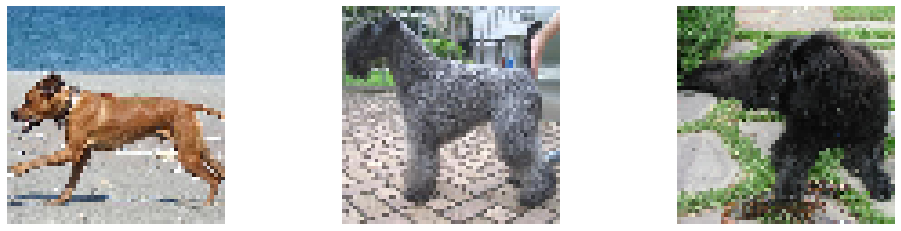

In [13]:
#test_img = true_dog.head(3).apply(load_preprocess)#
test_img = true_dog.sample(3).apply(load_preprocess)
test_img = inverse_trans(test_img)
imtest = test_img.values
plt.figure(figsize=(17,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.axis('off')
    plt.imshow(imtest[i])
plt.show()


# 2 Création du modèle
## 2.1 Inputs et Paramètres

In [14]:
"""True image for discriminator"""
img_true = tf.placeholder(tf.float32, shape=(None, d, d, 3))

"""Generator input"""
dr=100
x_rand =tf.placeholder(tf.float32, shape=(None, dr))

"""other parameter"""
is_test = tf.placeholder(tf.bool)
rate = tf.cond(is_test, true_fn=lambda :0.0, false_fn=lambda:0.30)

lrG=tf.placeholder(tf.float32)
lrD=tf.placeholder(tf.float32)

**Note:** Ici, j'ai définie les learning rates ('lrD' et'lrG') comme placeholder afin d'éventuellement le faire varier sans mofifier directement le modèle.

# 2.2 Fonctions :

In [15]:
def batchnorm(Ylogits,Offset, Scale, is_test=is_test,iteration=20, conv=True,scope='batch_normalization', ):
    """La fonction de Batchnomalisation met à jour les moments si nous somme dans le cardre d'entrainement. 
    Sinon, la fonction utilisera les moments appris"""
    decay=0.9
    c=Ylogits.get_shape().as_list()[-1]  
    if conv:
        mean, variance = tf.nn.moments(Ylogits, [0,1,2])  
    else:
        mean, variance = tf.nn.moments(Ylogits, [0])
    with tf.variable_scope(scope, reuse=tf.AUTO_REUSE):
        """stocke les refs :"""
        test_mean = tf.get_variable("pop_mean", shape=[c], dtype=tf.float32, initializer=tf.constant_initializer(0.0), trainable=False)
        test_var = tf.get_variable("pop_var", shape=[c], dtype=tf.float32, initializer=tf.constant_initializer(1.0), trainable=False)
        
        maj_m, maj_v=tf.cond(is_test, 
                    lambda: (test_mean, test_var),
                    lambda :(tf.assign(test_mean, test_mean * decay + mean * (1 - decay)),tf.assign(test_var, test_var * decay + variance * (1 - decay))))
    with tf.control_dependencies([maj_m, maj_v]):
        ema_mean = tf.cond(is_test, lambda: test_mean, lambda:mean )
        ema_var = tf.cond(is_test, lambda: test_var, lambda:variance )
        Ybn = tf.nn.batch_normalization(Ylogits,ema_mean,ema_var, offset=Offset, scale=1, variance_epsilon=1e-5)   
    return Ybn

In [17]:
#source :https://github.com/taki0112/BigGAN-Tensorflow/blob/master/ops.py
def batchnorm_cond(x, z, is_training=True, scope='batch_norm'):
    with tf.variable_scope(scope) :
        #_, _, _, c = x.get_shape().as_list()
        c = x.get_shape().as_list()[-1]
        print('c=',c, x.get_shape().as_list())
        decay = 0.9
        epsilon = 1e-05

        test_mean = tf.get_variable("pop_mean", shape=[c], dtype=tf.float32, initializer=tf.constant_initializer(0.0), trainable=False)
        test_var = tf.get_variable("pop_var", shape=[c], dtype=tf.float32, initializer=tf.constant_initializer(1.0), trainable=False)

        beta = fully_conneted(z, units=c, scope='beta')
        gamma = fully_conneted(z, units=c, scope='gamma')

        beta = tf.reshape(beta, shape=[-1, 1, 1, c])
        gamma = tf.reshape(gamma, shape=[-1, 1, 1, c])

        if is_training:
            batch_mean, batch_var = tf.nn.moments(x, [0, 1, 2])
            ema_mean = tf.assign(test_mean, test_mean * decay + batch_mean * (1 - decay))
            ema_var = tf.assign(test_var, test_var * decay + batch_var * (1 - decay))

            with tf.control_dependencies([ema_mean, ema_var]):
                return tf.nn.batch_normalization(x, batch_mean, batch_var, beta, gamma, epsilon)
        else:
            return tf.nn.batch_normalization(x, test_mean, test_var, beta, gamma, epsilon)

**note**: Ma fonction batchnorm_cond présente un léger bias, en effet j'aurais du utiliser 'is_test' pour ne pas mettre à jour les paramètres 'test_mean et test_var lors de la phase de test. Je n'ai pas corriger cette erreur pour ne pas réentrainer mon modèle.

In [18]:
def cross_entropy(y_true, y_pred):
    return -tf.reduce_sum(y_true*tf.log(tf.maximum(y_pred,1e-9))+(1-y_true)*tf.log(tf.maximum(1-y_pred,1e-9)))
    #return -tf.reduce_sum((y_true*tf.log(y_pred-1e-5)+(1-y_true)*tf.log(1-y_pred+1e-5)))


In [19]:
def hw_flatten(x):
    #x_shape=x.get_shape().as_list()
    return tf.reshape(x, shape=[tf.shape(x)[0], -1, tf.shape(x)[-1]])

In [20]:
def flatten(x) :
    #return tf.reshape(x, shape=[tf.shape(x)[0], -1])
    return tf.keras.layers.Flatten()(x)

In [21]:
def max_pooling(x):
    #x = tf.layers.max_pooling2d(x, pool_size=2, strides=2, padding='SAME')
    x = tf.nn.max_pool2d(x, ksize=2, strides=2, padding='SAME')
    return x

In [22]:
def spectral_norm(w, scope, iteration=1):
    w_shape = w.shape.as_list()
    w = tf.reshape(w, [-1, w_shape[-1]])
    with tf.variable_scope(scope, reuse=tf.AUTO_REUSE):
        u = tf.get_variable("u", [1, w_shape[-1]], initializer=tf.random_normal_initializer(), trainable=False)
    u_hat = u
    v_hat = None
    for i in range(iteration):
        """
        power iteration
        Usually iteration = 1 will be enough
        """
        v_ = tf.matmul(u_hat, tf.transpose(w))
        v_hat = tf.nn.l2_normalize(v_)
        u_ = tf.matmul(v_hat, w)
        u_hat = tf.nn.l2_normalize(u_)
    u_hat = tf.stop_gradient(u_hat)
    v_hat = tf.stop_gradient(v_hat)
    sigma = tf.matmul(tf.matmul(v_hat, w), tf.transpose(u_hat))
    with tf.control_dependencies([u.assign(u_hat)]):
        w_norm = w / sigma
        w_norm = tf.reshape(w_norm, w_shape)
    return w_norm

In [23]:
weights_init = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)
weight_init = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.02)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Nous Utiliserons la **Normalisation Orthogonale sur le générateur** :

In [24]:
#https://github.com/taki0112/BigGAN-Tensorflow
def orthogonal_regularizer(scale):
    def ortho(w):
        w_shape=w.get_shape().as_list()
        print(w.get_shape().as_list())
        c=w_shape[-1]
        w=tf.reshape(w, [-1,c])
        identity = tf.eye(c)
        
        w_transp = tf.transpose(w)
        print(w_transp)
        corr = tf.matmul(w_transp, w)
        print(corr)
        reg = tf.subtract(corr, identity)
        print(reg)
        
        loss_orth = tf.nn.l2_loss(reg)
        return scale*loss_orth
    return ortho
reg_weights = orthogonal_regularizer(0.0001)

In [25]:
def orthogonal_regularizer_fully(scale) :
    """ Defining the Orthogonal regularizer and return the function at last to be used in Fully Connected Layer """

    def ortho_reg_fully(w) :
        """ Reshaping the matrix in to 2D tensor for enforcing orthogonality"""
        _, c = w.get_shape().as_list()

        """Declaring a Identity Tensor of appropriate size"""
        identity = tf.eye(c)
        w_transpose = tf.transpose(w)
        w_mul = tf.matmul(w_transpose, w)
        reg = tf.subtract(w_mul, identity)

        """ Calculating the Loss """
        ortho_loss = tf.nn.l2_loss(reg)

        return scale * ortho_loss

    return ortho_reg_fully
weight_regularizer_fully = orthogonal_regularizer_fully(0.0001)

Afin de transformer **les couches de convolution du Discriminateur en couche dense**, nous laissons la possibilité d'utiliser la fonction ci dessous **'global_sum_pooling'** plutôt que flatten() afin de limiter le nombre de paramètres entrainables:

In [26]:
def global_sum_pooling(x) :
    gsp = tf.reduce_sum(x, axis=[1, 2])
    return gsp

In [27]:
def fully_conneted(x, units, use_bias=True, sn=False, scope='fully_0'):
    with tf.variable_scope(scope):
        x = flatten(x)
        shape = x.get_shape().as_list()
        channels = shape[-1]
        print(channels)
        #channels=tf.Variable(channels, trainable=False)
        if sn :
            if scope.__contains__('gen'):
                w = tf.get_variable("kerneldense", [channels, units], tf.float32, initializer=weights_init, regularizer=weight_regularizer_fully)
            else :
                w = tf.get_variable("kerneldense", shape=[channels, units], dtype=tf.float32, initializer=weights_init, regularizer=None)
                #[channels, units],tf.float32
            if use_bias :
                bias = tf.get_variable("biasdense", [units], initializer=tf.constant_initializer(0.0))

                x = tf.matmul(x, spectral_norm(w, scope+'_sn')) + bias
            else :
                x = tf.matmul(x, spectral_norm(w, scope+'_sn'))

        else :
            if scope.__contains__('gen'):
                x = tf.keras.layers.Dense(units=units, kernel_initializer=weights_init,
                                    kernel_regularizer=weight_regularizer_fully, use_bias=use_bias)(x)
            else :
                print('x',x,'--units',units, scope)
                x = tf.keras.layers.Dense(units=units, kernel_initializer=weights_init,
                                    kernel_regularizer=None, use_bias=use_bias)(x)

        return x


# 2.3 Architecture du modèle
## 2.3.1 Discriminator
### Variables for the discriminator model

In [28]:
#Discriminant
#K=22*22*64
K=3*3*128
M=2000
n=1




with tf.name_scope('discrim'):
    """Varible_D"""
    Wconv = tf.Variable(tf.truncated_normal([3,3,3,96],mean=0, stddev=0.02))
    bconv=tf.Variable(tf.zeros([96]))
    Wconv2 = tf.Variable(tf.truncated_normal([3,3,96,96],mean=0, stddev=0.02))
    bconv2 = tf.Variable(tf.zeros([96]))
    Wpoolconv1 = tf.Variable(tf.truncated_normal([3,3,96,128],mean=0, stddev=0.02))
    bpoolconv1 = tf.Variable(tf.zeros([128]))
    Wconv3 = tf.Variable(tf.truncated_normal([3,3,128,256],mean=0, stddev=0.02))
    bconv3 = tf.Variable(tf.zeros([256]))
    Wconv4 = tf.Variable(tf.truncated_normal([4,4,256,512],mean=0, stddev=0.02))
    bconv4 = tf.Variable(tf.zeros([512]))#124
    Wconv5 = tf.Variable(tf.truncated_normal([3,3,512,512],mean=0, stddev=0.02))
    bconv5 = tf.Variable(tf.zeros([512]))#124
    
    with tf.device("/cpu:0"):
        Wpoolconv2 = tf.Variable(tf.truncated_normal([3,3,512,1024],mean=0, stddev=0.02))
        bpoolconv2 = tf.Variable(tf.zeros([1024]))
    #Wpoolconv3 = tf.Variable(tf.truncated_normal([2,2,256,1],mean=0, stddev=0.1))
        """Variables FullyConnected"""
        #W1=tf.Variable(tf.truncated_normal([K,M], mean=0, stddev=0.1))
        #b1=tf.Variable(tf.zeros([M]))

    #W2=tf.Variable(tf.truncated_normal([M,M], mean=0, stddev=0.1))
    #b2=tf.Variable(tf.zeros([M]))

    #W3=tf.Variable(tf.truncated_normal([M,M], mean=0, stddev=0.1))
    #b3=tf.Variable(tf.zeros([M]))

        W4=tf.Variable(tf.truncated_normal([1024,n],mean=0, stddev=0.02))
        b4=tf.Variable(tf.truncated_normal([n],mean=0, stddev=0.02), name="b4")
    #print(X.shape[0], b2, Wconv, Wconv3)
    """Ajout des Variables pour les Blocks RESIDUELS"""
    Dskip1=tf.Variable(tf.truncated_normal([1,1,3,96],mean=0, stddev=0.02))
    bskip1=tf.Variable(tf.zeros([96]))
    Dskip2=tf.Variable(tf.truncated_normal([5,5,96,256], mean=0, stddev=0.02))
    bskip2=tf.Variable(tf.zeros([256]))
    Dskip3=tf.Variable(tf.truncated_normal([7,7,256,512], mean=0, stddev=0.02))
    bskip3=tf.Variable(tf.zeros([512]))
    #Dskip3=tf.Variable(tf.truncated_normal([5,5,64,64], mean=0, stddev=0.02))
    
    """self-Attention"""
    wDf=tf.Variable(tf.truncated_normal([1,1,256,256//8], mean=0, stddev=0.02))
    bDf=tf.Variable(tf.zeros([64]))
    wDg=tf.Variable(tf.truncated_normal([1,1,256,256//8], mean=0, stddev=0.02))
    bDg=tf.Variable(tf.zeros([64]))
    wDh=tf.Variable(tf.truncated_normal([1,1,256,256//2], mean=0, stddev=0.02))
    bDh=tf.Variable(tf.zeros([128]))
    wDo=tf.Variable(tf.truncated_normal([1,1,128,256], mean=0, stddev=0.02))
    Dgamma=tf.Variable(tf.zeros([1]))
    dsa_b=tf.Variable(tf.zeros([256]))

### Discriminator layers

In [29]:
def discriminant(Img):
    """convolutions :"""
    Xconv_lin0=tf.nn.conv2d(Img, filter=spectral_norm(Wconv, 'Wconv'), strides = [1,1],padding='SAME')#(60*60*32)
    Xconv_lin = batchnorm(Xconv_lin0, bconv, 1, conv=True, scope='Xconv_lin')
    Xconv = tf.nn.relu(Xconv_lin)
    #Xconv = tf.nn.dropout(Xconv, rate=rate)
    print(Xconv)

    Xconv_lin2=tf.nn.conv2d(Xconv, filter=spectral_norm(Wconv2, 'Wconv2'), strides = [1,1],padding='SAME')
    Xconv_lin2 = batchnorm(Xconv_lin2, bconv2, 1, conv=True, scope='Xconv2')
    Xconv2 = tf.nn.relu(Xconv_lin2)
    
    shortcut1=tf.nn.conv2d(Img, spectral_norm(Dskip1, 'Dskip1'), strides = [1,1],padding='SAME')
    shortcut1=batchnorm(shortcut1, bskip1, 1, conv=True, scope='Xconv2shortcut')
    Xconv2=Xconv2+shortcut1
    #Xconv2 = tf.nn.dropout(Xconv2, rate=rate)
    print('Xconv2', Xconv2)#60*60*64
    #Xpool=tf.nn.pool(Xconv2, [5,5], 'MAX', strides=[5,5], padding='VALID')#(12*12*64)
    
    Xpool = tf.nn.conv2d(Xconv2, spectral_norm(Wpoolconv1, 'Wpoolconv1'), strides=[2,2], padding='SAME')#[[0,0],[2,2],[2,2],[0,0]])#padding='VALID')
    Xpool = batchnorm(Xpool, bpoolconv1, 1, conv=True, scope='Xpool1')
    Xpool = tf.nn.relu(Xpool)#30*30*64
    print('DXpool', Xpool)
    Xconv_lin3=tf.nn.conv2d(Xpool, filter=spectral_norm(Wconv3, 'Wconv3'), strides = [1,1],padding='SAME')
    Xconv_lin3 = batchnorm(Xconv_lin3, bconv3, 1, conv=True, scope='Xconv3')
    Xconv3 = tf.nn.relu(Xconv_lin3)
    #Xconv3 = tf.nn.dropout(Xconv3, rate=rate)
    print('Dconv3',Xconv3)
    shortcut2=tf.nn.conv2d(Xconv2, spectral_norm(Dskip2, 'Dskip2'), strides=[2,2], padding='SAME')
    shortcut2=batchnorm(shortcut2, bskip2, 1, conv=True, scope='Xconv3shortcut')
    Xconv3=Xconv3+shortcut2
    print('Dconv3',Xconv3)
    
    """self-attention"""
    
    
    Dfx=tf.nn.conv2d(Xconv3, spectral_norm(wDf, 'wDf'), strides=1, padding='SAME')#outch=32
    #Dfx=max_pooling(Dfx)
    Dgx=tf.nn.conv2d(Xconv3, spectral_norm(wDg, 'wDg'), strides=1, padding='SAME')#outch=32
    Dhx=tf.nn.conv2d(Xconv3, spectral_norm(wDh, 'wDh'), strides=1, padding='SAME')#outch=128
    #Dhx=max_pooling(Dhx)#(bs, h/2, w/2, c/2)
    
    Ds=tf.matmul(hw_flatten(Dgx), hw_flatten(Dfx), transpose_b=True)#(bs, N, N/2)
    Dbeta=tf.nn.softmax(Ds)
    
    Do=tf.matmul(Dbeta, hw_flatten(Dhx))#(bs, N, c/2)
    Do=tf.reshape(Do, (-1, 30,30,128))
    Do=tf.nn.conv2d(Do, spectral_norm(wDo, 'wDo'), strides=1, padding='SAME')
    Dsa=Dgamma*Do+Xconv3#(30*30*128)
    Dsa=batchnorm(Dsa, Offset=dsa_b, Scale=1, conv=True, scope='Dsa')
    Dsa=tf.nn.relu(Dsa)
    #Dsa=Xconv3
    
    Xconv_lin4=tf.nn.conv2d(Dsa, filter=spectral_norm(Wconv4, 'Wconv4'), strides=3 ,padding='SAME')
    Xconv_lin4 = batchnorm(Xconv_lin4, bconv4, 1, conv=True, scope='Xconv_lin_4')
    Xconv4 = tf.nn.relu(Xconv_lin4)#10*10*64
    #Xconv4 = tf.nn.dropout(Xconv4, rate=rate)
    print('xconv4',Xconv4)
    Xconv_lin5=tf.nn.conv2d(Xconv4, filter=spectral_norm(Wconv5, 'Wconv5'), strides=2 ,padding='SAME')
    Xconv_lin5 = batchnorm(Xconv_lin5, bconv5, 1, conv=True, scope='Xconvlin5')#5*5*128
    Xconv5 = tf.nn.relu(Xconv_lin5)
    print('Xconv5',Xconv5)
    shortcut3=tf.nn.conv2d(Dsa, spectral_norm(Dskip3, 'Dskip3'), strides=[6,6], padding=[[0,0],[1,1],[1,1],[0,0]])
    shortcut3=batchnorm(shortcut3, bskip3, 1, conv=True, scope='Xconv5shortcut')
    Xconv5=Xconv5+shortcut3

    #Xconv=tf.nn.pool(Xconv4, [4,4], 'MAX', strides=[4,4], padding='VALID')#(3*3*124)
    Xpool2=tf.nn.conv2d(Xconv5, spectral_norm(Wpoolconv2, 'Wpoolconv2'), strides=[2,2],padding='VALID')
    Xpool2 = batchnorm(Xpool2, bpoolconv2, 1, conv=True, scope='Xpool2')
    Xpool2 = tf.nn.relu(Xpool2)
    #Xconv=tf.nn.dropout(Xconv, rate=rate)
    print(Xpool, Xconv)
    
    X1=global_sum_pooling(Xpool2)
    """Fully Connected"""

    #X1_lin=tf.matmul(tf.reshape(Xpool2, (-1, Xconv.shape[1]*Xconv.shape[2]*Xconv.shape[3])), W1)
    
    #X1_lin = batchnorm(X1_lin, Offset=b1, Scale=1, conv=False)

    #X1=tf.nn.relu(X1_lin)
    #X1 = tf.nn.dropout(X1, rate=rate)
    #X1=tf.nn.elu(tf.matmul(tf.reshape(Xconv, (-1, Xconv.shape[1]*Xconv.shape[2]*Xconv.shape[3])), W1)+b1)
    #Y = tf.nn.softmax(tf.matmul(X1, W2)+b2, axis=2)


    #X2_lin=tf.matmul(X1, W2)
    #X2_lin = batchnorm(X2_lin, Offset=b2, Scale=1, conv=False)
    #X2 = tf.nn.relu(X2_lin)
    #X2 = tf.nn.dropout(X2, rate=rate)

    #X3_lin=tf.matmul(X2, W3)
    #X3_lin= batchnorm(X3_lin, Offset=b2, Scale=1, conv=False)
    #X3=tf.nn.relu(X3_lin)
    #X3 = tf.nn.dropout(X3, rate=rate)
    #print('X3discr',X3)
    Y = tf.matmul(X1, spectral_norm(W4, 'W4'))+b4
    #Y = tf.nn.sigmoid(tf.matmul(X1, spectral_norm(W4, 'W4'))+b4)
    print('y',Y)
    return Y

## 2.3.2 Generator
### Variables for generator :

In [30]:
with tf.variable_scope("gen"): 
    #gen1 = tf.Variable(tf.truncated_normal([dr,9*dr*3], mean=0, stddev=0.1))
    #genb1=tf.Variable(tf.zeros([9*dr*3]))
    #print(gen1)
    with tf.device("/cpu:0"):
        g_conv0 = tf.get_variable('g_conv', [5,5,1024, dr], initializer=weights_init, regularizer=reg_weights)
        gc0_b= tf.Variable(tf.zeros([1024]))
    
    g_conv1=tf.get_variable('g_conv1',[3,3,512, 1024], initializer=weights_init, regularizer=reg_weights)
    gc1_b = tf.Variable(tf.zeros([512]))
    print(g_conv1)
    
    g_conv2 = tf.get_variable('g_conv2',[3,3,512, 512], initializer=weights_init, regularizer=reg_weights)
    gc2_b = tf.Variable(tf.zeros([512]))
    print(g_conv2)


    g_conv3=tf.get_variable('g_conv3',[4,4,256,512], initializer=weights_init, regularizer=reg_weights)#5,5
    gc3_b = tf.Variable(tf.zeros([256]))
    
    g_conv3_2=tf.get_variable('g_conv3_2',[3,3,256, 128], initializer=weights_init, regularizer=reg_weights)
    gc3_2_b=tf.Variable(tf.zeros([128]))
    
    g_conv4=tf.get_variable('g_conv4',[3,3,64,128], initializer=weights_init, regularizer=reg_weights)
    gc4_b = tf.Variable(tf.zeros([64]))

    g_conv5=tf.get_variable('g_conv5', [3,3,64,64], initializer=weights_init, regularizer=reg_weights)
    gc5_b = tf.Variable(tf.zeros([64]))
    #gc5_a = tf.Variable(tf.truncated_normal([3], mean=1, stddev=0.1))
    
    g_conv6=tf.get_variable('g_conv6', [3,3,64,3], initializer=weights_init, regularizer=reg_weights)
    gc6_b = tf.Variable(tf.zeros([3]))
    gc6_a = tf.get_variable('gc6_a',[3], initializer=weights_init, regularizer=reg_weights)
    
    """skipUp"""
    Gskip1=tf.get_variable('Gskip1',[4,4,512,1024], initializer=weights_init, regularizer=reg_weights)
    Gb1=tf.Variable(tf.zeros([512]))
    
    Gskip2=tf.get_variable('Gskip2', [4,4,128,512], initializer=weights_init, regularizer=reg_weights)
    Gb2=tf.Variable(tf.zeros([128]))
    
    Gskip3=tf.get_variable('Gskip3', [4,4,64,128], initializer=weights_init, regularizer=reg_weights)
    Gb3=tf.Variable(tf.zeros([64]))
    
    """Self-Attention"""
    wGf=tf.get_variable('wGf',[1,1,128,16], initializer=weights_init, regularizer=reg_weights)
    bGf=tf.Variable(tf.zeros([16]))
    wGg=tf.get_variable('wGg',[1,1,128,16], initializer=weights_init, regularizer=reg_weights)
    bGg=tf.Variable(tf.zeros([16]))
    wGh=tf.get_variable('wGh',[1,1,128,64], initializer=weights_init, regularizer=reg_weights)
    bGh=tf.Variable(tf.zeros([64]))
    wGo=tf.get_variable('wGo',[1,1,64,128], initializer=weights_init, regularizer=reg_weights)
    #Ggamma=tf.Variable(tf.zeros([1]))
    Ggamma = tf.get_variable("gamma", [1], initializer=tf.constant_initializer(0.0))#gen/  
    gsa_b = tf.Variable(tf.zeros([128]))
    

[5, 5, 1024, 100]
Tensor("gen/g_conv/Regularizer/transpose:0", shape=(100, 25600), dtype=float32, device=/device:CPU:0)
Tensor("gen/g_conv/Regularizer/MatMul:0", shape=(100, 100), dtype=float32, device=/device:CPU:0)
Tensor("gen/g_conv/Regularizer/Sub:0", shape=(100, 100), dtype=float32, device=/device:CPU:0)
[3, 3, 512, 1024]
Tensor("gen/g_conv1/Regularizer/transpose:0", shape=(1024, 4608), dtype=float32)
Tensor("gen/g_conv1/Regularizer/MatMul:0", shape=(1024, 1024), dtype=float32)
Tensor("gen/g_conv1/Regularizer/Sub:0", shape=(1024, 1024), dtype=float32)
<tf.Variable 'gen/g_conv1:0' shape=(3, 3, 512, 1024) dtype=float32_ref>
[3, 3, 512, 512]
Tensor("gen/g_conv2/Regularizer/transpose:0", shape=(512, 4608), dtype=float32)
Tensor("gen/g_conv2/Regularizer/MatMul:0", shape=(512, 512), dtype=float32)
Tensor("gen/g_conv2/Regularizer/Sub:0", shape=(512, 512), dtype=float32)
<tf.Variable 'gen/g_conv2:0' shape=(3, 3, 512, 512) dtype=float32_ref>
[4, 4, 256, 512]
Tensor("gen/g_conv3/Regularizer

### Generator Layers

In [31]:
def generator(x_rand=x_rand):
    """Split z"""
    split_dim=100//5
    remain=100%5
    if remain == 0 :
        z_split = tf.split(x_rand, num_or_size_splits=[split_dim] * 5, axis=-1)
    else :
        z_split=tf.split(x_rand,  num_or_size_splits=[split_dim]*4+[remain+split_dim], axis=-1)
    print(z_split)
    sn=True
    bs=tf.shape(x_rand)[0]
    with tf.variable_scope('gen'):
        gen_conv0 = fully_conneted(z_split[0], units=5 * 5 * 1024, sn=sn, scope='gen_dense')
        gen_conv0 = tf.reshape(gen_conv0, shape=[-1, 5, 5, 1024])
        gen_conv0=batchnorm_cond(gen_conv0, z_split[1], scope='gen_conv0')
        gen_conv0=tf.nn.relu(gen_conv0)
        #x_rand = tf.reshape(x_rand, (bs,1,1,dr))
        #out0=tf.stack([bs, 5,5,1024])#dr*3
        #gen_conv0=tf.nn.conv2d_transpose(x_rand, spectral_norm(g_conv0, 'g_conv0'), output_shape=out0, strides=[1,1], padding='VALID')
        #gen_conv0=batchnorm(gen_conv0, Offset=gc0_b, Scale=1, conv=True, scope='gen_conv0')
        print('gen0',gen_conv0)
        #gen_conv0=tf.reshape(dense1, (-1,3,3,dr*3))

        #gen_conv1=tf.nn.conv2d(gen_conv0,g_conv1, strides=1, padding='SAME')
        #gen_conv1=batchnorm(gen_conv1, Offset=gc1_b, Scale=1, conv=True)
        #gen_conv1=tf.nn.relu(gen_conv1)#3*3*128
        #print('conv1',gen_conv1)

        #bs=tf.shape(gen_conv1)[0]
        #in_ = tf.constant(0.1, shape=[2,9,9,64])
        #in_conv = tf.nn.conv2d(in_, g_conv2, strides=[3,1], padding='SAME')
        #print(in_conv)
        out2=tf.stack([bs, 10,10,512])
        gen_conv1_t=tf.nn.conv2d_transpose(gen_conv0, spectral_norm(g_conv1, 'g_conv1'), output_shape=out2, strides=[2,2], padding='SAME')
        print(gen_conv1_t)
        gen_conv1=batchnorm_cond(gen_conv1_t, z_split[1], scope='gen_conv1')
        gen_conv1=tf.nn.relu(gen_conv1)
        print('conv1',gen_conv1)

        gen_conv2=tf.nn.conv2d(gen_conv1, spectral_norm(g_conv2, 'g_conv2'), strides=1, padding='SAME')
        gen_conv2=batchnorm_cond(gen_conv2, z_split[1],scope='gen_conv2')
        gen_conv2=tf.nn.relu(gen_conv2)

        Gshortcut1=tf.nn.conv2d_transpose(gen_conv0, spectral_norm(Gskip1, 'Gskip1'), output_shape=out2, strides=[2,2], padding='SAME')
        Gshortcut1=batchnorm_cond(Gshortcut1, z_split[1], scope='gen_conv2shortcut')
        gen_conv2=gen_conv2+Gshortcut1
        gen_conv2=tf.nn.relu(gen_conv2)


        out3=tf.stack([bs, 30,30,256])
        gen_conv3=tf.nn.conv2d_transpose(gen_conv2, spectral_norm(g_conv3, 'g_conv3'), output_shape=out3, strides=3, padding='SAME')#[1,3,3,2]
        gen_conv3=batchnorm_cond(gen_conv3, z_split[2], scope='gen_conv3')
        gen_conv3=tf.nn.relu(gen_conv3)
        print('conv3', gen_conv3, g_conv3)
        gen_conv3_2 = tf.nn.conv2d(gen_conv3, spectral_norm(g_conv3_2, 'g_conv3_2'), strides=1, padding='SAME')
        gen_conv3_2 = batchnorm_cond(gen_conv3_2, z_split[2], scope='gen_conv3_2')
        out3_2=tf.stack([bs, 30,30,128])
        Gshortcut2=tf.nn.conv2d_transpose(gen_conv2, spectral_norm(Gskip2, 'Gskip2'), output_shape=out3_2, strides=[3,3], padding='SAME')
        Gshortcut2 = batchnorm_cond(Gshortcut2, z_split[2], scope='gen_conv3shortcut')
        print('short1', Gshortcut1)
        gen_conv3=gen_conv3_2+Gshortcut2
        gen_conv3=tf.nn.relu(gen_conv3)

        """self Attention"""
        #with tf.device("/cpu:0"):

        Gfx=tf.nn.conv2d(gen_conv3, spectral_norm(wGf, 'wGf') , strides=1, padding='SAME')#outch=32
        #Gfx=max_pooling(Gfx)
        Ggx=tf.nn.conv2d(gen_conv3, spectral_norm(wGg, 'wGg'), strides=1, padding='SAME')#outch=32
        Ghx=tf.nn.conv2d(gen_conv3, spectral_norm(wGh, 'wGh'), strides=1, padding='SAME')#outch=128
        #Ghx=max_pooling(Ghx)#(bs, h/2, w/2, c/2)

        Gs=tf.matmul(hw_flatten(Ggx), hw_flatten(Gfx), transpose_b=True)#(bs, N, N/2)
        Gbeta=tf.nn.softmax(Gs)

        Go=tf.matmul(Gbeta, hw_flatten(Ghx))#(bs, N, c/2)
        Go=tf.reshape(Go, (bs, 30,30,64))
        Go=tf.nn.conv2d(Go, spectral_norm(wGo, 'wGo'), strides=1, padding='SAME')
        Gsa=Ggamma*Go+gen_conv3
        Gsa=batchnorm_cond(Gsa, z_split[3], scope='Gsa')
        Gsa=tf.nn.relu(Gsa)
        #Gsa=gen_conv3
        print('G self-attention', Gsa)
        out4=tf.stack([bs, 60,60,64])
        gen_conv4=tf.nn.conv2d_transpose(Gsa, spectral_norm(g_conv4, 'g_conv4'), output_shape=out4, strides=[2,2], padding='SAME')
        gen_conv4=batchnorm_cond(gen_conv4, z_split[4], scope='gen_conv4')
        gen_conv4=tf.nn.relu(gen_conv4)
        print('conv4', gen_conv4)

        #Gshortcut2=tf.nn.conv2d_transpose(gen_conv2, Gskip2, output_shape=out4, strides=[6,6], padding='SAME')
        #Gshortcut2 = batchnorm(Gshortcut2, Offset=Gb2, Scale=1, conv=True)
        #gen_conv2=gen_conv2+Gshortcut1
        gen_conv5=tf.nn.conv2d(gen_conv4, spectral_norm(g_conv5, 'g_conv5'), strides=[1,1], padding='SAME')
        gen_conv5=batchnorm_cond(gen_conv5, z_split[4], scope='gen_conv5')

        out5=tf.stack([bs, 60,60,64])#32
        Gshortcut3=tf.nn.conv2d_transpose(Gsa, spectral_norm(Gskip3, 'Gskip3'), output_shape=out5, strides=[2,2], padding='SAME')
        Gshortcut3=batchnorm_cond(Gshortcut3, z_split[4], scope='gen_conv5shortcut')
        gen_conv5=gen_conv5+Gshortcut3
        gen_conv5=tf.nn.relu(gen_conv5)
        #out5=tf.stack([bs, d,d,3])
        #gen_conv5=tf.nn.conv2d_transpose(gen_conv4, g_conv5, output_shape=out5, strides=[1,1], padding='VALID')#(bs,d,d,3)
        #gen_conv5=batchnorm(gen_conv5, Offset=gc5_b, Scale=gc5_a, conv=True)
        print('conv5', gen_conv5)
        gen_conv6=tf.nn.conv2d(gen_conv5, spectral_norm(g_conv6, 'g_conv6'), strides=[1,1], padding='SAME')#(bs,d,d,3)
        gen_conv6=batchnorm_cond(gen_conv6, z_split[4], scope='gen_conv6')
        gen_conv6=tf.nn.tanh(gen_conv6)
        #print('conv6', gen_conv6)
        return gen_conv6

# 2.4 Training step
Training step pour le générateur:

In [32]:
#lrG=0.001
optimizer_gen = tf.train.AdamOptimizer(learning_rate=lrG, beta1=0.5, beta2=0.999)
img_fake=generator(x_rand)
Y_fake_pred = discriminant(img_fake)
"""hinge"""
loss_gen =-tf.reduce_mean(Y_fake_pred)
"""cross entropy"""
#loss_gen =cross_entropy(tf.ones_like(Y_fake_pred), Y_fake_pred)
train_gen = optimizer_gen.minimize(loss_gen, var_list=tf.trainable_variables(scope='gen'))#


[<tf.Tensor 'split:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'split:1' shape=(?, 20) dtype=float32>, <tf.Tensor 'split:2' shape=(?, 20) dtype=float32>, <tf.Tensor 'split:3' shape=(?, 20) dtype=float32>, <tf.Tensor 'split:4' shape=(?, 20) dtype=float32>]
20
c= 1024 [None, 5, 5, 1024]
20
x Tensor("gen_1/gen_conv0/beta/flatten_1/Reshape:0", shape=(?, 20), dtype=float32) --units 1024 beta
20
x Tensor("gen_1/gen_conv0/gamma/flatten_2/Reshape:0", shape=(?, 20), dtype=float32) --units 1024 gamma
gen0 Tensor("gen_1/Relu:0", shape=(?, 5, 5, 1024), dtype=float32)
Tensor("gen_1/conv2d_transpose:0", shape=(?, 10, 10, 512), dtype=float32)
c= 512 [None, 10, 10, 512]
20
x Tensor("gen_1/gen_conv1/beta/flatten_3/Reshape:0", shape=(?, 20), dtype=float32) --units 512 beta
20
x Tensor("gen_1/gen_conv1/gamma/flatten_4/Reshape:0", shape=(?, 20), dtype=float32) --units 512 gamma
conv1 Tensor("gen_1/Relu_1:0", shape=(?, 10, 10, 512), dtype=float32)
c= 512 [None, 10, 10, 512]
20
x Tensor("gen_1/gen_conv2/bet

Training step pour le discriminant :

In [33]:

"""Our discriminator target"""
Y_fake = tf.zeros((tf.shape(img_fake)[0], 1))+0.05*tf.random.uniform((tf.shape(img_fake)[0], 1),minval=0, maxval=1)
Y_true = tf.ones((tf.shape(img_true)[0], 1))-0.05*tf.random.uniform((tf.shape(img_true)[0], 1),minval=0, maxval=1)
"""steps"""
Y_real_pred = discriminant(img_true)
"""Hing_Loss"""
real_loss = tf.reduce_mean(tf.nn.relu(1.0 - Y_real_pred))
fake_loss = tf.reduce_mean(tf.nn.relu(1.0 + Y_fake_pred))


"""Cross Entropy"""
#real_loss = tf.reduce_mean(tf.nn.sigmoid(Y_real_pred))
#fake_loss = tf.reduce_mean(tf.nn.sigmoid(Y_fake_pred))
#loss_discr = cross_entropy(Y_true, Y_real_pred)+cross_entropy(Y_fake, Y_fake_pred)
loss_discr = real_loss + fake_loss
#lrD=0.001
print(lrD)
optimizer = tf.train.AdamOptimizer(learning_rate=lrD, beta1=0.5, beta2=0.999)
train_step=optimizer.minimize(loss_discr, var_list=tf.trainable_variables(scope='discrim'))


init = tf.global_variables_initializer()

Tensor("Relu_8:0", shape=(?, 60, 60, 96), dtype=float32)
Xconv2 Tensor("add_6:0", shape=(?, 60, 60, 96), dtype=float32)
DXpool Tensor("Relu_10:0", shape=(?, 30, 30, 128), dtype=float32)
Dconv3 Tensor("Relu_11:0", shape=(?, 30, 30, 256), dtype=float32)
Dconv3 Tensor("add_7:0", shape=(?, 30, 30, 256), dtype=float32)
xconv4 Tensor("Relu_13:0", shape=(?, 10, 10, 512), dtype=float32)
Xconv5 Tensor("Relu_14:0", shape=(?, 5, 5, 512), dtype=float32)
Tensor("Relu_10:0", shape=(?, 30, 30, 128), dtype=float32) Tensor("Relu_8:0", shape=(?, 60, 60, 96), dtype=float32)
y Tensor("add_10:0", shape=(?, 1), dtype=float32)
Tensor("Placeholder_4:0", dtype=float32)


# 3 Entrainement du modèle
## Variables d'entrainements :

In [34]:
tf.compat.v1.trainable_variables()

[<tf.Variable 'discrim/Variable:0' shape=(3, 3, 3, 96) dtype=float32_ref>,
 <tf.Variable 'discrim/Variable_1:0' shape=(96,) dtype=float32_ref>,
 <tf.Variable 'discrim/Variable_2:0' shape=(3, 3, 96, 96) dtype=float32_ref>,
 <tf.Variable 'discrim/Variable_3:0' shape=(96,) dtype=float32_ref>,
 <tf.Variable 'discrim/Variable_4:0' shape=(3, 3, 96, 128) dtype=float32_ref>,
 <tf.Variable 'discrim/Variable_5:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'discrim/Variable_6:0' shape=(3, 3, 128, 256) dtype=float32_ref>,
 <tf.Variable 'discrim/Variable_7:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'discrim/Variable_8:0' shape=(4, 4, 256, 512) dtype=float32_ref>,
 <tf.Variable 'discrim/Variable_9:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'discrim/Variable_10:0' shape=(3, 3, 512, 512) dtype=float32_ref>,
 <tf.Variable 'discrim/Variable_11:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'discrim/Variable_12:0' shape=(3, 3, 512, 1024) dtype=float32_ref>,
 <tf.Variable 'discrim/Var

In [35]:
saver=tf.train.Saver()

## Boucle d'apprentissage :

INFO:tensorflow:Restoring parameters from ./m_gan_dog_condBNc.h5
0.5 ----------
loss_G : 3.855489
loss_D:  0.25029543


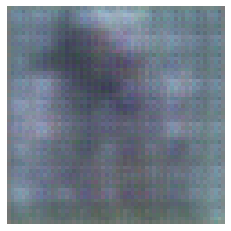

1.0 ----------
loss_G : 0.49417317
loss_D:  0.70148367


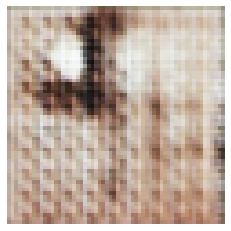

1.5 ----------
loss_G : 0.024377933
loss_D:  0.6508618


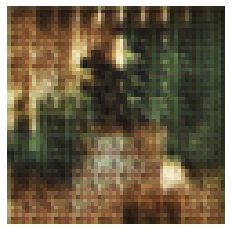

2.0 ----------
loss_G : 0.034452464
loss_D:  0.6922512


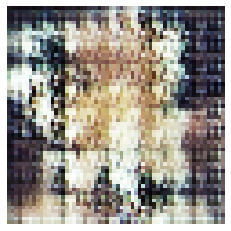

2.5 ----------
loss_G : -0.14487588
loss_D:  0.7222537


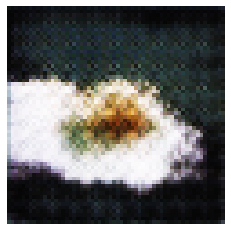

3.0 ----------
loss_G : -0.24224095
loss_D:  0.7765358


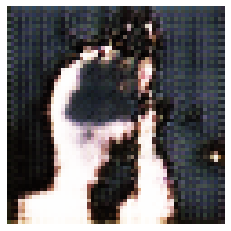

3.5 ----------
loss_G : -0.2557753
loss_D:  0.6895059


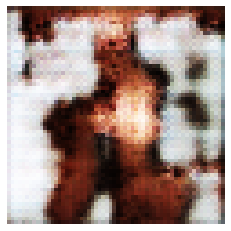

4.0 ----------
loss_G : -0.13065483
loss_D:  0.5923873


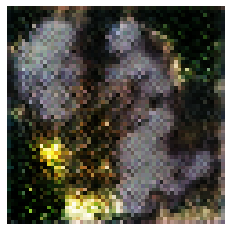

4.5 ----------
loss_G : -0.18470359
loss_D:  0.56055456


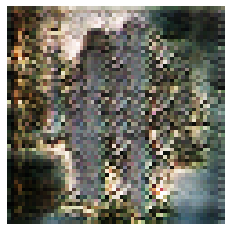

5.0 ----------
loss_G : -0.24954826
loss_D:  0.53167695


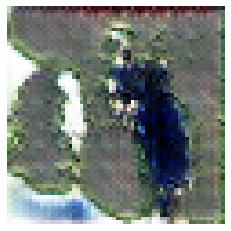

5.5 ----------
loss_G : -0.22359358
loss_D:  0.43921304


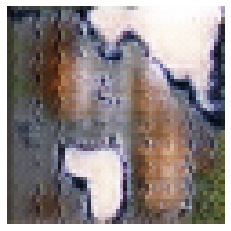

6.0 ----------
loss_G : -0.24950907
loss_D:  0.4422842


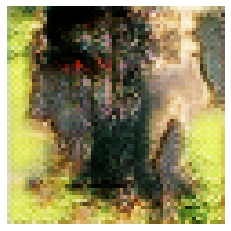

6.5 ----------
loss_G : -0.245452
loss_D:  0.43083706


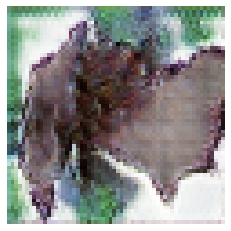

7.0 ----------
loss_G : -0.18914922
loss_D:  0.37342703


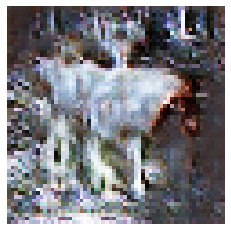

7.5 ----------
loss_G : -0.14742336
loss_D:  0.35748592


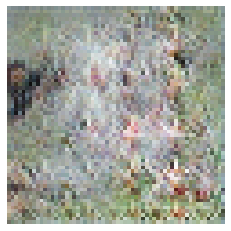

8.0 ----------
loss_G : -0.13327694
loss_D:  0.31010592


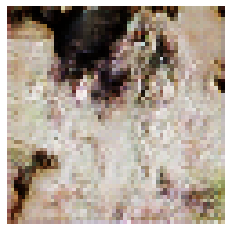

8.5 ----------
loss_G : -0.08613067
loss_D:  0.2969627


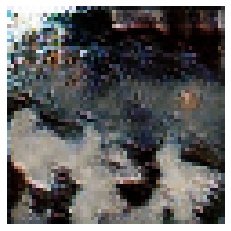

9.0 ----------
loss_G : -0.17522934
loss_D:  0.27479848


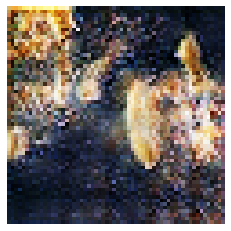

9.5 ----------
loss_G : -0.09559017
loss_D:  0.24264793


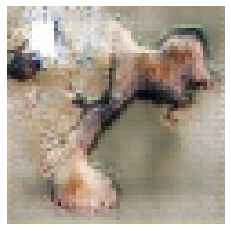

10.0 ----------
loss_G : -0.09845365
loss_D:  0.23138838


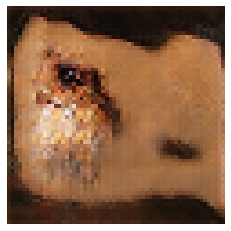

10.5 ----------
loss_G : -0.0845973
loss_D:  0.19064188


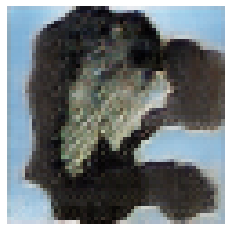

11.0 ----------
loss_G : -0.054898515
loss_D:  0.2022808


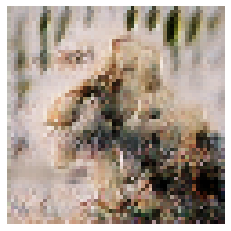

11.5 ----------
loss_G : -0.028421761
loss_D:  0.16376843


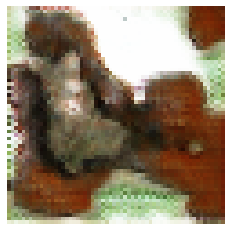

12.0 ----------
loss_G : 0.11542397
loss_D:  0.14268045


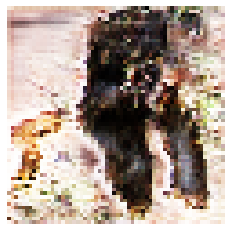

12.5 ----------
loss_G : 0.0882651
loss_D:  0.12771337


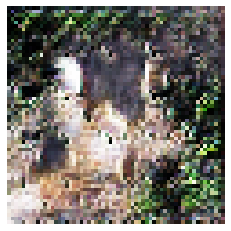

13.0 ----------
loss_G : 0.0556405
loss_D:  0.13675399


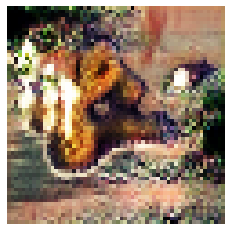

13.5 ----------
loss_G : 0.056124266
loss_D:  0.12571757


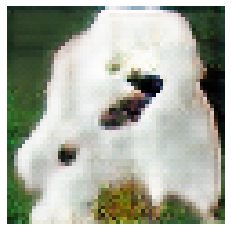

14.0 ----------
loss_G : 0.22238559
loss_D:  0.09366658


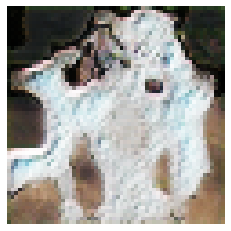

14.5 ----------
loss_G : 0.2109503
loss_D:  0.09232222


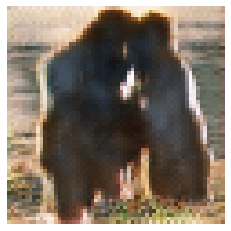

15.0 ----------
loss_G : 0.15314595
loss_D:  0.11025926


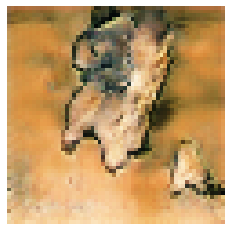

15.5 ----------
loss_G : 0.17569967
loss_D:  0.10619601


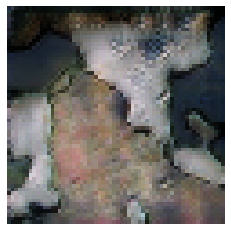

16.0 ----------
loss_G : 0.18905392
loss_D:  0.093082875


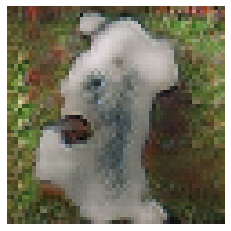

16.5 ----------
loss_G : 0.21352726
loss_D:  0.08025262


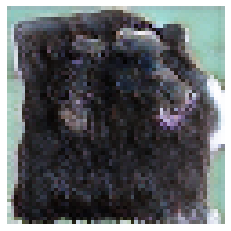

17.0 ----------
loss_G : 0.23443578
loss_D:  0.08872477


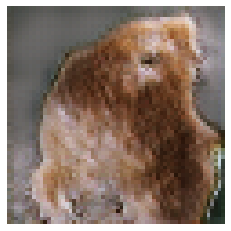

17.5 ----------
loss_G : 0.20891422
loss_D:  0.075305715


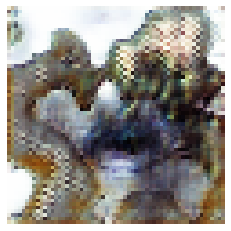

18.0 ----------
loss_G : 0.18073288
loss_D:  0.06322446


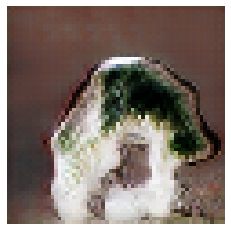

18.5 ----------
loss_G : 0.2330388
loss_D:  0.07656158


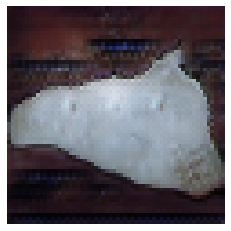

19.0 ----------
loss_G : 0.31369495
loss_D:  0.06826539


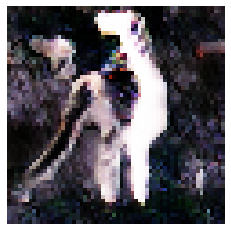

19.5 ----------
loss_G : 0.24124412
loss_D:  0.07763352


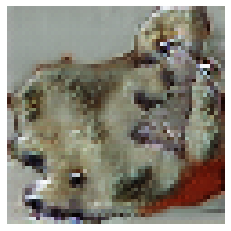

20.0 ----------
loss_G : 0.18177673
loss_D:  0.07229912


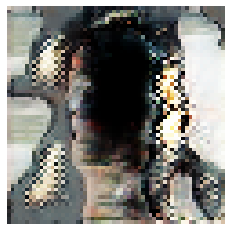

20.5 ----------
loss_G : 0.10307346
loss_D:  0.06059917


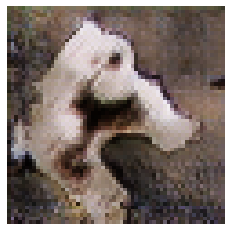

21.0 ----------
loss_G : 0.31644762
loss_D:  0.054892857


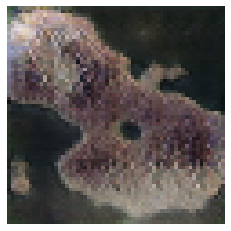

21.5 ----------
loss_G : 0.27058834
loss_D:  0.066255234


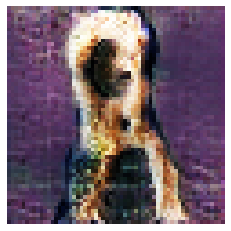

22.0 ----------
loss_G : 0.26484963
loss_D:  0.0692079


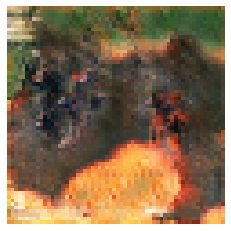

22.5 ----------
loss_G : 0.29703
loss_D:  0.051044527


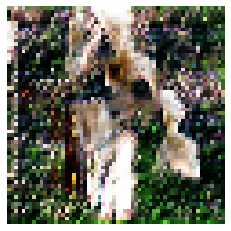

23.0 ----------
loss_G : 0.33644608
loss_D:  0.06635818


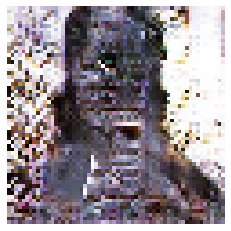

23.5 ----------
loss_G : 0.28872463
loss_D:  0.06562525


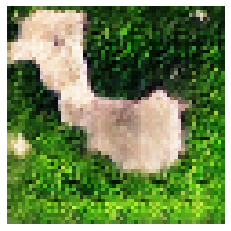

24.0 ----------
loss_G : 0.16341414
loss_D:  0.04531675


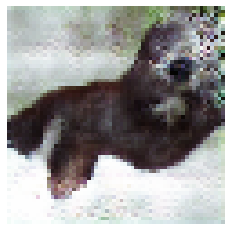

24.5 ----------
loss_G : 0.31506363
loss_D:  0.056700297


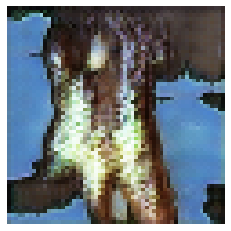

25.0 ----------
loss_G : 0.33615372
loss_D:  0.05996161


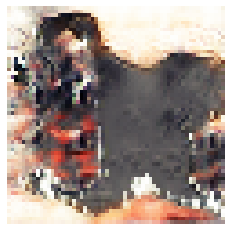

25.5 ----------
loss_G : 0.37212142
loss_D:  0.046783466


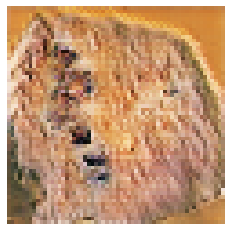

26.0 ----------
loss_G : 0.37614378
loss_D:  0.04606966


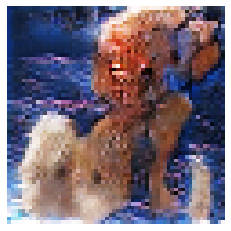

26.5 ----------
loss_G : 0.4323884
loss_D:  0.029073553


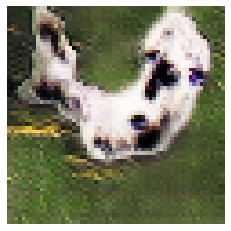

27.0 ----------
loss_G : 0.4942557
loss_D:  0.03912911


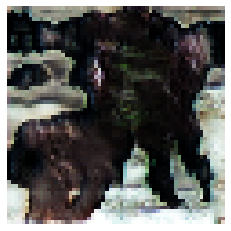

27.5 ----------
loss_G : 0.41432253
loss_D:  0.031322766


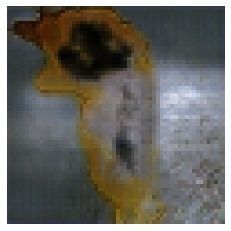

28.0 ----------
loss_G : 0.48520654
loss_D:  0.043222453


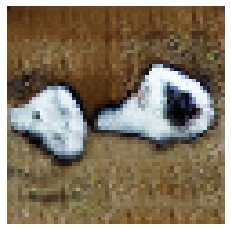

28.5 ----------
loss_G : 0.36340213
loss_D:  0.03030199


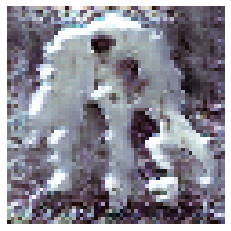

29.0 ----------
loss_G : 0.41827726
loss_D:  0.030713003


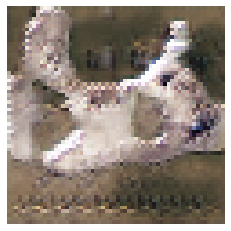

29.5 ----------
loss_G : 0.46962836
loss_D:  0.03926655


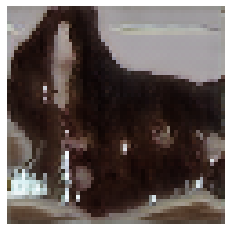

30.0 ----------
loss_G : 0.39593682
loss_D:  0.030339172


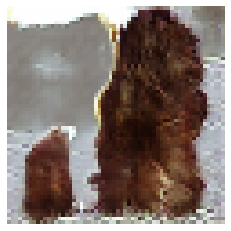

30.5 ----------
loss_G : 0.44858322
loss_D:  0.036325987


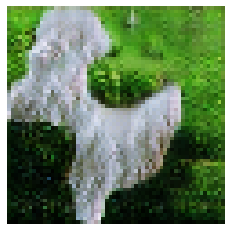

31.0 ----------
loss_G : 0.4769174
loss_D:  0.029094096


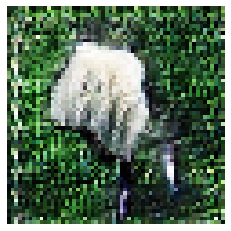

31.5 ----------
loss_G : 0.5355026
loss_D:  0.029753147


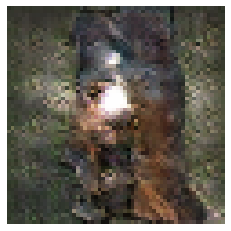

32.0 ----------
loss_G : 0.59845215
loss_D:  0.023706079


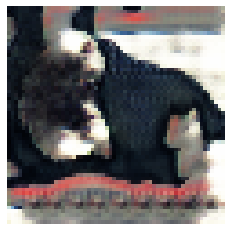

32.5 ----------
loss_G : 0.5159007
loss_D:  0.032812588


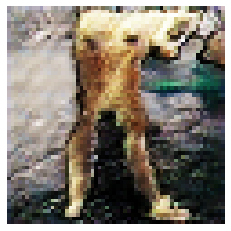

33.0 ----------
loss_G : 0.47677192
loss_D:  0.034064062


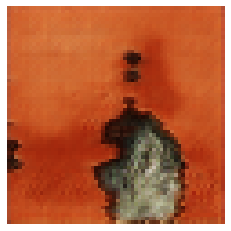

33.5 ----------
loss_G : 0.5640247
loss_D:  0.036223657


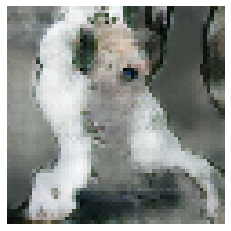

34.0 ----------
loss_G : 0.5303832
loss_D:  0.030688938


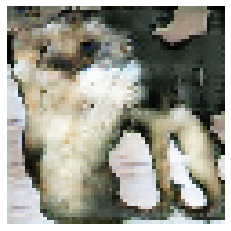

34.5 ----------
loss_G : 0.75044435
loss_D:  0.034818027


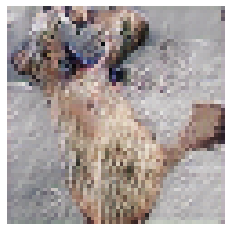

35.0 ----------
loss_G : 0.7322147
loss_D:  0.02271176


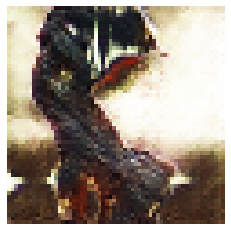

35.5 ----------
loss_G : 0.6092962
loss_D:  0.0251519


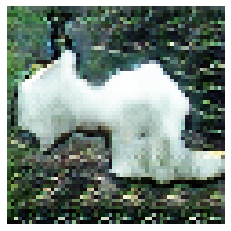

36.0 ----------
loss_G : 0.5984298
loss_D:  0.033845115


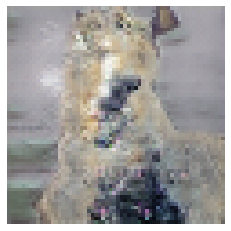

36.5 ----------
loss_G : 0.6696483
loss_D:  0.033765975


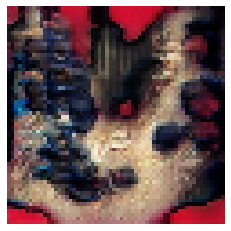

37.0 ----------
loss_G : 0.64444435
loss_D:  0.027975563


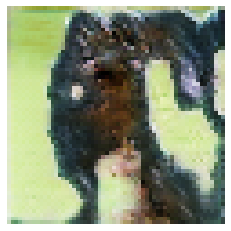

37.5 ----------
loss_G : 0.63217425
loss_D:  0.024984058


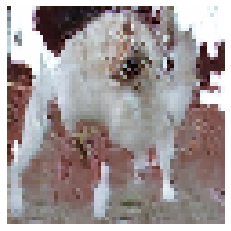

38.0 ----------
loss_G : 0.6087148
loss_D:  0.027014887


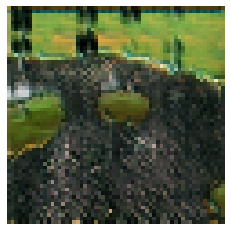

38.5 ----------
loss_G : 0.5985104
loss_D:  0.024181586


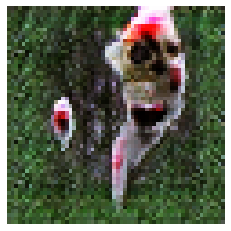

39.0 ----------
loss_G : 0.6433986
loss_D:  0.019993877


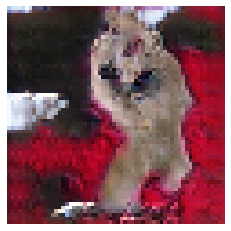

39.5 ----------
loss_G : 0.73313195
loss_D:  0.028647441


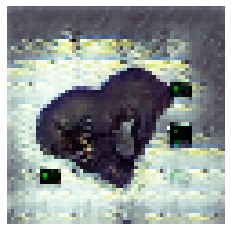

40.0 ----------
loss_G : 0.71303093
loss_D:  0.03365193


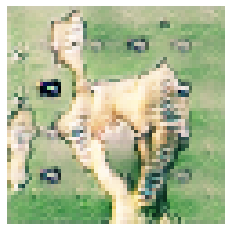

40.5 ----------
loss_G : 0.8156291
loss_D:  0.015939616


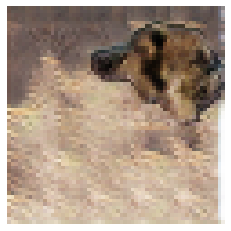

41.0 ----------
loss_G : 0.779428
loss_D:  0.024705935


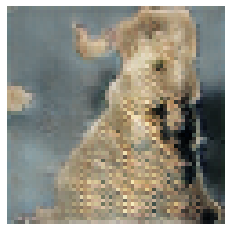

KeyboardInterrupt: 

In [41]:
nb_true = 30#per batch
nb_fake = 30

Y_ref = np.vstack((np.ones((nb_true,1)), np.zeros((nb_fake,1))))                
loop=200

init = tf.global_variables_initializer()
with tf.Session() as sess:
    #sess.run(init)
    saver.restore(sess, './m_gan_dog_condBNc.h5')
    loss=[0]
    loss_g=[0]
    ma_loss_g=[]
    ma_loss_d=[]
    for e in range(loop):
        loss_generator =[]
        loss_discreminant=[]
        
        for i in range(step//2):#step//2
            #true = true_dog.sample(nb_true).apply(load_preprocess)
            #true, lab_true = next(iter(img_tr))
            true = img_gen.load_batch()
            #X_rand = np.random.random([nb_fake,dr])
            X_rand= truncnorm.rvs(-1,1,0,1,size=100*nb_fake)#(-0.5/0.3, 0.5/0.3, 0.5, 0.3, size=100*nb_fake)#truncated normal between 0 and 1 with mean 0.5 and std 0.3
            X_rand=X_rand.reshape((nb_fake, 100))
            #print(X_rand.shape)
            #gen_feed = {x_rand:X_rand, is_test:False}
            #X_fake = sess.run(img_fake, feed_dict=gen_feed)
            #plt.figure()
            #plt.imshow(X_fake[0])
            #plt.show()
            X_true = np.array(list(true))
            #lrg, lrd=synchro_G_D(loss_g[0], loss[0])
            lrg, lrd =0.0004,0.0004#0.001,0.001#test_lossD(loss[0])0.0004,0.0001ref:0.00005,0.0002,  
            #print('lrg', lrg)
            feed_dict = {x_rand:X_rand, img_true:X_true, is_test:False,lrG:lrg, lrD:lrd}# Y_:Y_ref
            sess.run(train_step, feed_dict=feed_dict)
            loss= sess.run([loss_discr], feed_dict=feed_dict)#gen_conv2_tcross_entropy
            sess.run(train_gen, feed_dict=feed_dict)
            loss_g = sess.run([loss_gen], feed_dict=feed_dict)
            loss_generator.append(loss_g)
            loss_discreminant.append(loss)
        mean_loss_g=np.mean(loss_generator)
        mean_loss_d=np.mean(loss_discreminant)
        #print(e,'-'*10)
        print((e/2)+0.5,'-'*10)
        print('loss_G :',mean_loss_g)
        print('loss_D: ',mean_loss_d)
        ma_loss_g.append(mean_loss_g)
        ma_loss_d.append(mean_loss_d)
        gen_feed = {x_rand:X_rand, is_test:True}
        X_fake = sess.run(img_fake, feed_dict=gen_feed)
        #print(c)
        X_test=inverse_trans(X_fake[0])
        plt.figure(figsize=(4,4))
        plt.imshow(X_test)
        plt.axis('off')
        plt.show()
        saver.save(sess, './m_gan_dog_condBNc.h5')#04
        #if np.isnan(loss):
        #    break

Text(0.5, 1.0, 'Loss')

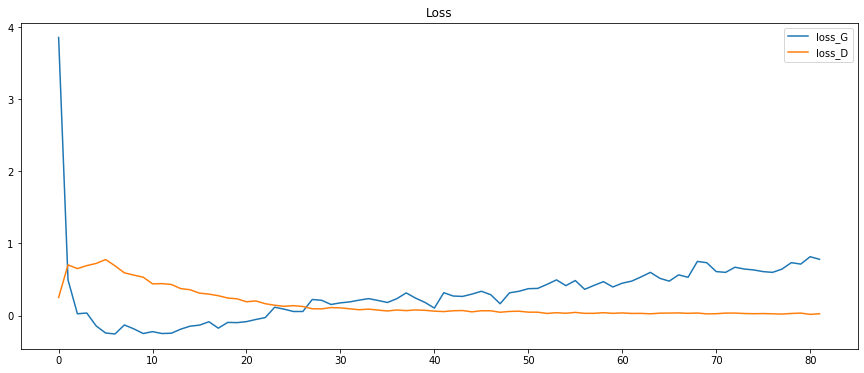

In [42]:
plt.figure(figsize=(15,6))
plt.plot(ma_loss_g)
plt.plot(ma_loss_d)
plt.legend(['loss_G','loss_D'])
plt.title('Loss')

In [38]:
tf.Session()

In [39]:
tf.ConfigProto()

# Visualisation de la variétée des Images générées
Nous allons générer 10 images à partir de notre modèle entrainé ci-dessus :

INFO:tensorflow:Restoring parameters from ./m_gan_dog_condBNc.h5
(10, 100)
(10, 60, 60, 3)


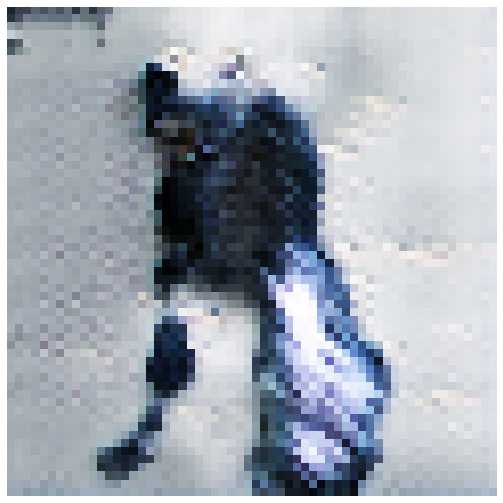

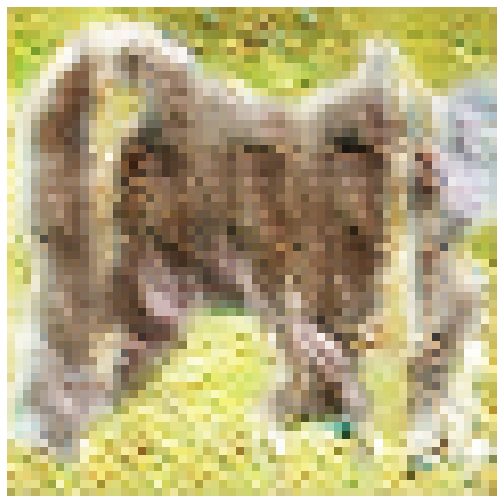

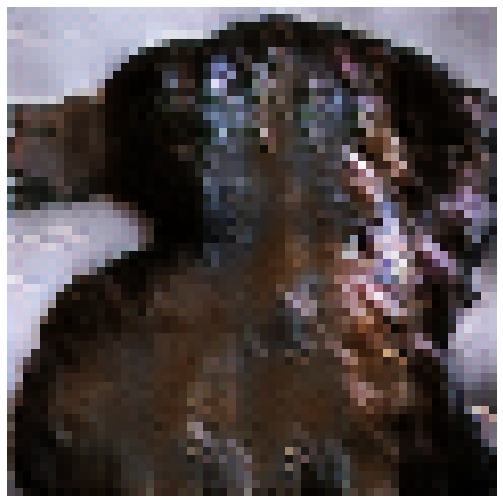

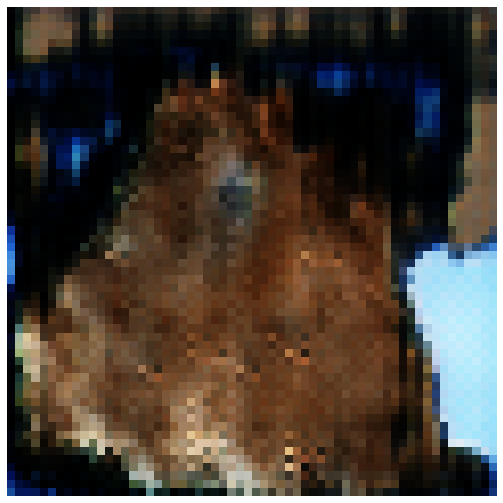

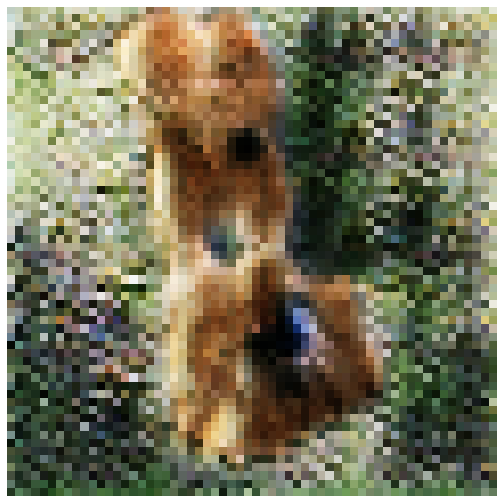

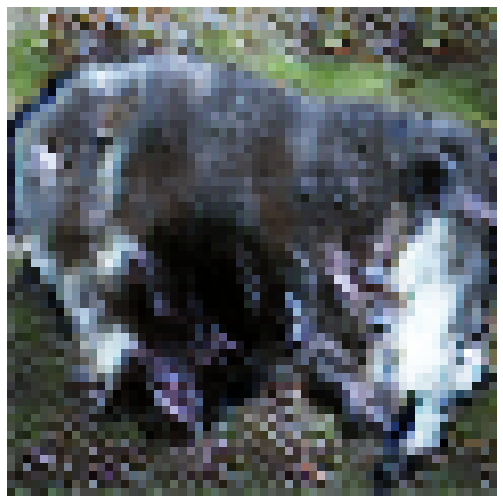

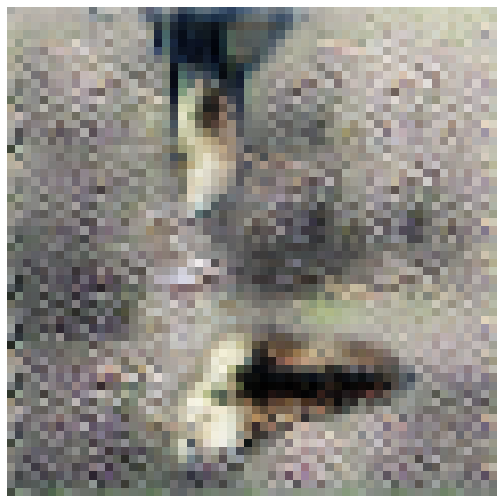

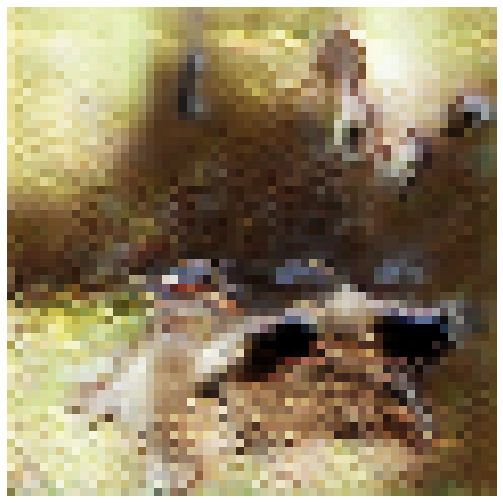

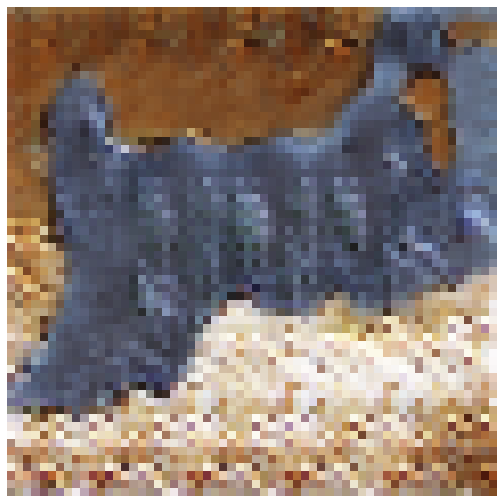

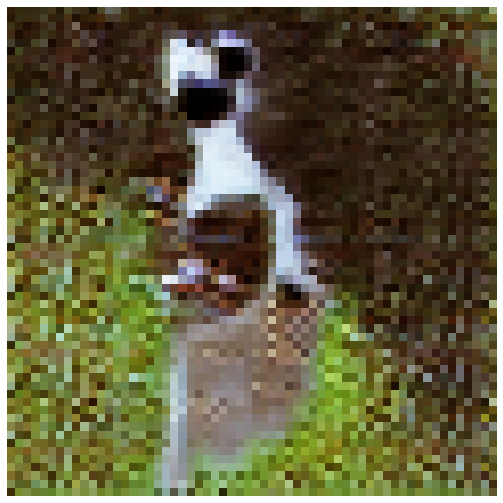

In [43]:
with tf.Session() as sess:
    saver.restore(sess, './m_gan_dog_condBNc.h5')
    i=10
    X_r= truncnorm.rvs(-1,1,0,1,size=100*i)#(-0.5/0.3, 0.5/0.3, 0.5, 0.3, size=100*nb_fake)#truncated normal between 0 and 1 with mean 0.5 and std 0.3
    X_r=X_r.reshape((i, 100))
    #X_r=np.random.random([i,100])
    print(X_r.shape)
    gen_feed = {x_rand:X_r, is_test:True, lrG:lrg, lrD:lrd}
    X_fake = sess.run(img_fake, feed_dict=gen_feed)
    print(X_fake.shape)
    for j in range(i):    
        plt.figure(figsize=(9,9))
        img_test = inverse_trans(X_fake[j])
        plt.imshow(img_test)
        plt.axis('off')
        plt.show()


# Conclusion
En comparaison avec le précedent modèle, la Conditional Batch Normalization a clairement permis au modèle d'engendrer plus de **variété**. Ci-dessus, chaque vecteur z en entrée a généré une image différente.<br> De plus, j'ai stoppé l'entrainement mais le modèle pourrait encore s'améliorer.

In [45]:
#tf.compat.v1.trainable_variables('gen')
